# Spectral siren cosmology

In this notebook we perform a hierarchical Bayesian inference to constrain both cosmology and astrophysics. We *assume* a parametric model in both cases. 

You can use the [injection campaign](injection_campaign.ipynb)  notebook to compute the sensitivity of a given detector and [mock population](mock_population.ipynb) to generate a mock population of sources. 
If you prefere, you can also use a set of injections and a mock population provided by us in this Zenodo repository [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.10655745.svg)](https://doi.org/10.5281/zenodo.10655745). You can download it using `zenodo_get`:

```bash
zenodo_get 10.5281/zenodo.10655745
unzip simulated_gw_data.zip
```

The inference is performed using [numpyro](https://num.pyro.ai), a probabilistic programming language built on top of [JAX](https://github.com/google/jax). The inference is performed using MCMC, and we use the NUTS sampler.

The inference can be accelerated running it on GPUs. See installation instructions.

In [1]:
import numpy as np

#Numpyro and friends
import numpyro
from numpyro.infer import NUTS,MCMC
import numpyro.distributions as dist
import jax
from jax import random
from jax.config import config
import jax.numpy as jnp
import arviz as az
import h5py

config.update("jax_enable_x64", True)

#JAX MODULES
from spectral_sirens.utils.constants import *
from spectral_sirens.cosmology import jgwcosmo
from spectral_sirens.gw_population import jgwpop
from spectral_sirens.bayesian_inference import likelihood as lik

/groups/astro/ezquiaga/miniconda/envs/inference_gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Fiducial universe

We begin by choosing the detector sensitivity

In [2]:
#Detector
detector = 'A#'

Choose the relevant directories

In [3]:
#Directories
import os 
PATH = os.getcwd()
dir_plots='plots/plots_'+detector+'/'
dir_samples = 'samples/samples_'+detector+'/'
dir_inj = 'injections/injections_'+detector+'/'
dir_mock = 'mock_catalogues/mock_catalogues_'+detector+'/'

We also set the fiducial cosmology and astrophysical parameters.

In [4]:
#Fiducial universe
from fiducial_universe_gwtc3 import *
model_name = 'powerlaw_peak_smooth'
bq_fid = 0. 
model_name_with_params = model_name+'_alpha_%s_sig_%s_mu_%s_fpeak_%s_mmin_pl_%s_mmax_pl_%s_mmin_filt_%s_mmax_filt_%s_dmmin_%s_dmmax_%s '%(alpha_fid, sig_m1_fid, mu_m1_fid, f_peak_fid, mmin_pl_fid, mmax_pl_fid, mMin_filter_fid,mMax_filter_fid,dmMin_filter_fid,dmMax_filter_fid)


## Injections

We estimate the detector's sensitivity with simulated injections. We use the [injection campaign](injection_campaign.ipynb) notebook for this purpose. 

You can find an example of an injection set in the Zenodo repository.

In [5]:
#Injections
params = 'm1z_m2z_dL'

zmax = 15
alpha_inj, mmin_inj, mmax_inj = -0.3, 1., 100.
inj_details = 'Vz_zmax_%s_m1z_power_law_alpha_%s_mmin_%s_mmax_%s' % (zmax,alpha_inj,mmin_inj,mmax_inj)
Ndet = 2833658 
Ndraw = 25000000

#Reading the data
data = h5py.File(dir_inj+'injections_'+detector+'_'+params+'_'+inj_details+'_Ndraws_%s_Ndet_%s.hdf5' % (Ndraw,Ndet), "r")
m1z_inj = np.array(data['m1z_inj'])
m2z_inj = np.array(data['m2z_inj'])
dL_inj = np.array(data['dL_inj'])
p_draw_inj = np.array(data['p_draw_inj'])

print('Number of found injections: ',Ndet)
print('Number of draws: ',Ndraw)

Number of found injections:  2833658
Number of draws:  25000000


## Mock catalog

We use use a mock catalog of detected GWs that we generated using the [mock population](mock_population.ipynb) notebook. 

You can find an example of a mock catalog in the Zeno database. You can download it using the `zenodo_get` package.

In [6]:
#Mock data
n_samples = 200
n_detections = 1000
print('Number of detections: ',n_detections)
print('Number of samples: ',n_samples)

m1z_mock_samples = np.load(dir_mock+'m1z_'+detector+'_Ndet_%s_Nsamples_%s_' % (n_detections,n_samples)+model_name_with_params+'.npy')
m2z_mock_samples = np.load(dir_mock+'m2z_'+detector+'_Ndet_%s_Nsamples_%s_' % (n_detections,n_samples)+model_name_with_params+'.npy')
dL_mock_samples = np.load(dir_mock+'dL_'+detector+'_Ndet_%s_Nsamples_%s_' % (n_detections,n_samples)+model_name_with_params+'.npy')
pdraw_mock_samples= np.load(dir_mock+'pdraw_'+detector+'_Ndet_%s_Nsamples_%s_' % (n_detections,n_samples)+model_name_with_params+'.npy')


Number of detections:  1000
Number of samples:  200


---

## Inference

We begin by seting up the parameters of the mcmc: the number of samples, the number of chains, the number of warmup steps, etc. Their choices highly depend on whether you are aming a quick or more in-depth analysis. 

In any case, it is _recommended_ to check the convergence of the chains using the `arviz` package or looking at the summary statistics of the chains.

In [7]:
#MCMC
nChains = 1
numpyro.set_host_device_count(nChains)
num_warmup = 500 #CHANGE THIS TO ADJUST YOUR NEEDS
num_samples = 1000 #CHANGE THIS TO ADJUST YOUR NEEDS


We set the priors

In [8]:
#Priors
#---------------------
#Cosmo priors
h0_min, h0_max = 0.4, 1.
Om0_min, Om0_max = 0.15, 0.45
#p(m1) priors
alpha_min, alpha_max = -5., 0.
mmin_min, mmin_max = 1., 20.
mmax_min, mmax_max = 30., 100.
mu_m1_min, mu_m1_max = 20., 60.
sig_m1_min, sig_m1_max = 1., 10.
f_peak_min, f_peak_max = 0., 1e-6
#p(q) priors
bq_min, bq_max = 0., 1.
#p(z) priors
alpha_z_min, alpha_z_max = 1., 5.
zp_min, zp_max = 0., 4.
beta_min, beta_max = 0., 10.
#---------------------

For the inference we _fix_ some of the parameters to their fiducial values. This is done to reduce the dimensionality of the problem and to make the inference even faster. Feel free to play with this!

In [9]:
def log_probability():
    
    #Prior distributions
    h0 = numpyro.sample("h0",dist.Uniform(h0_min,h0_max))
    Om0 = numpyro.sample("Om0",dist.Uniform(Om0_min,Om0_max))
    mmin = numpyro.sample("mmin",dist.Uniform(mmin_min,mmin_max))
    mmax = numpyro.sample("mmax",dist.Uniform(mmax_min,mmax_max))
    alpha = numpyro.sample("alpha",dist.Uniform(alpha_min, alpha_max))
    mu_m1 = numpyro.sample("mu_m1",dist.Uniform(mu_m1_min,mu_m1_max))
    sig_m1 = numpyro.sample("sig_m1",dist.Uniform(sig_m1_min,sig_m1_max))
    f_peak = numpyro.sample("f_peak",dist.Uniform(f_peak_min,f_peak_max))
    alpha_z = numpyro.sample("alpha_z",dist.Uniform(alpha_z_min,alpha_z_max))
    #Fixed parameters
    bq = bq_fid # numpyro.sample("bq",dist.Uniform(bq_min,bq_max)) #when fitting m_2
    zp = zp_fid # numpyro.sample("zp",dist.Uniform(zp_min,zp_max))
    beta = beta_fid # numpyro.sample("beta",dist.Uniform(beta_min,beta_max))
    mmin_pl = mmin_pl_fid
    mmax_pl = mmax_pl_fid
    dmMin_filter = dmMin_filter_fid
    dmMax_filter = dmMax_filter_fid
    
    #Likelihood
    loglik, Neff = lik.log_lik(m1z_mock_samples,m2z_mock_samples,dL_mock_samples,pdraw_mock_samples,m1z_inj,m2z_inj,dL_inj,p_draw_inj,Ndraw,h0,Om0,mmin_pl,mmax_pl,alpha,sig_m1,mu_m1,f_peak,mmin,mmax,dmMin_filter,dmMax_filter,bq,alpha_z,zp,beta)
    
    #Convergence check: uncomment to check number of effective samples
    #conv = numpyro.deterministic('conv', Neff/4/n_detections)

    #Likelihood
    numpyro.factor("logp",loglik)

We run the inference

In [10]:
rng_key = random.PRNGKey(2)
rng_key,rng_key_ = random.split(rng_key)

# Set up NUTS sampler over our likelihood
kernel = NUTS(log_probability)
mcmc = MCMC(kernel,num_warmup=num_warmup,num_samples=num_samples,num_chains=nChains,chain_method='parallel',progress_bar=True)

inference_details = '_Ndet_%s_Nsamples_%s_Nfoundinj_%s_Ninj_%s' % (n_detections,n_samples,Ndet,Ndraw) +'_'+ inj_details

mcmc.run(rng_key_)
mcmc.print_summary()
samples = mcmc.get_samples()

print('Fiducial values:')
print('H0=',H0_fid,', Om0=',Om0_fid)
print('alpha=',alpha_fid,', bq=',bq_fid,', f_peak=',f_peak_fid,', mmax=',mMax_filter_fid,', mmin=',mMin_filter_fid,', mu_m1=',mu_m1_fid,', sig_m1=',sig_m1_fid)
print('alpha_z=',alpha_z_fid,', zp=',zp_fid,', beta=',beta_fid)

sample: 100%|██████████| 1500/1500 [12:51<00:00,  1.94it/s, 15 steps of size 7.15e-02. acc. prob=0.94] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       Om0      0.34      0.08      0.35      0.22      0.45    378.76      1.00
     alpha     -3.48      0.10     -3.48     -3.63     -3.32    397.36      1.01
   alpha_z      2.61      0.20      2.62      2.26      2.93    395.66      1.00
    f_peak      0.00      0.00      0.00      0.00      0.00    480.46      1.01
        h0      0.71      0.08      0.70      0.60      0.84    242.53      1.00
      mmax     88.22      3.82     87.62     82.26     94.66    222.53      1.00
      mmin      8.73      0.20      8.74      8.40      9.07    354.42      1.00
     mu_m1     33.06      1.03     33.07     31.49     34.92    295.53      1.00
    sig_m1      3.68      0.34      3.66      3.13      4.22    641.60      1.00

Number of divergences: 0
Fiducial values:
H0= 67.66 , Om0= 0.30966
alpha= -3.4 , bq= 0.0 , f_peak= 1.4e-08 , mmax= 87.0 , mmin= 8.75 , mu_m1= 34.0 , sig_m1= 3.6
alpha_z= 2.7 , zp= 1.9 , be

## Results

We plot the results of the inference for their analysis.

In [11]:
#PLOTS
import matplotlib.pyplot as plt
import corner
fontSz = 15
fontsz = 13
fontssz = 11
new_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']
%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## Trace plots

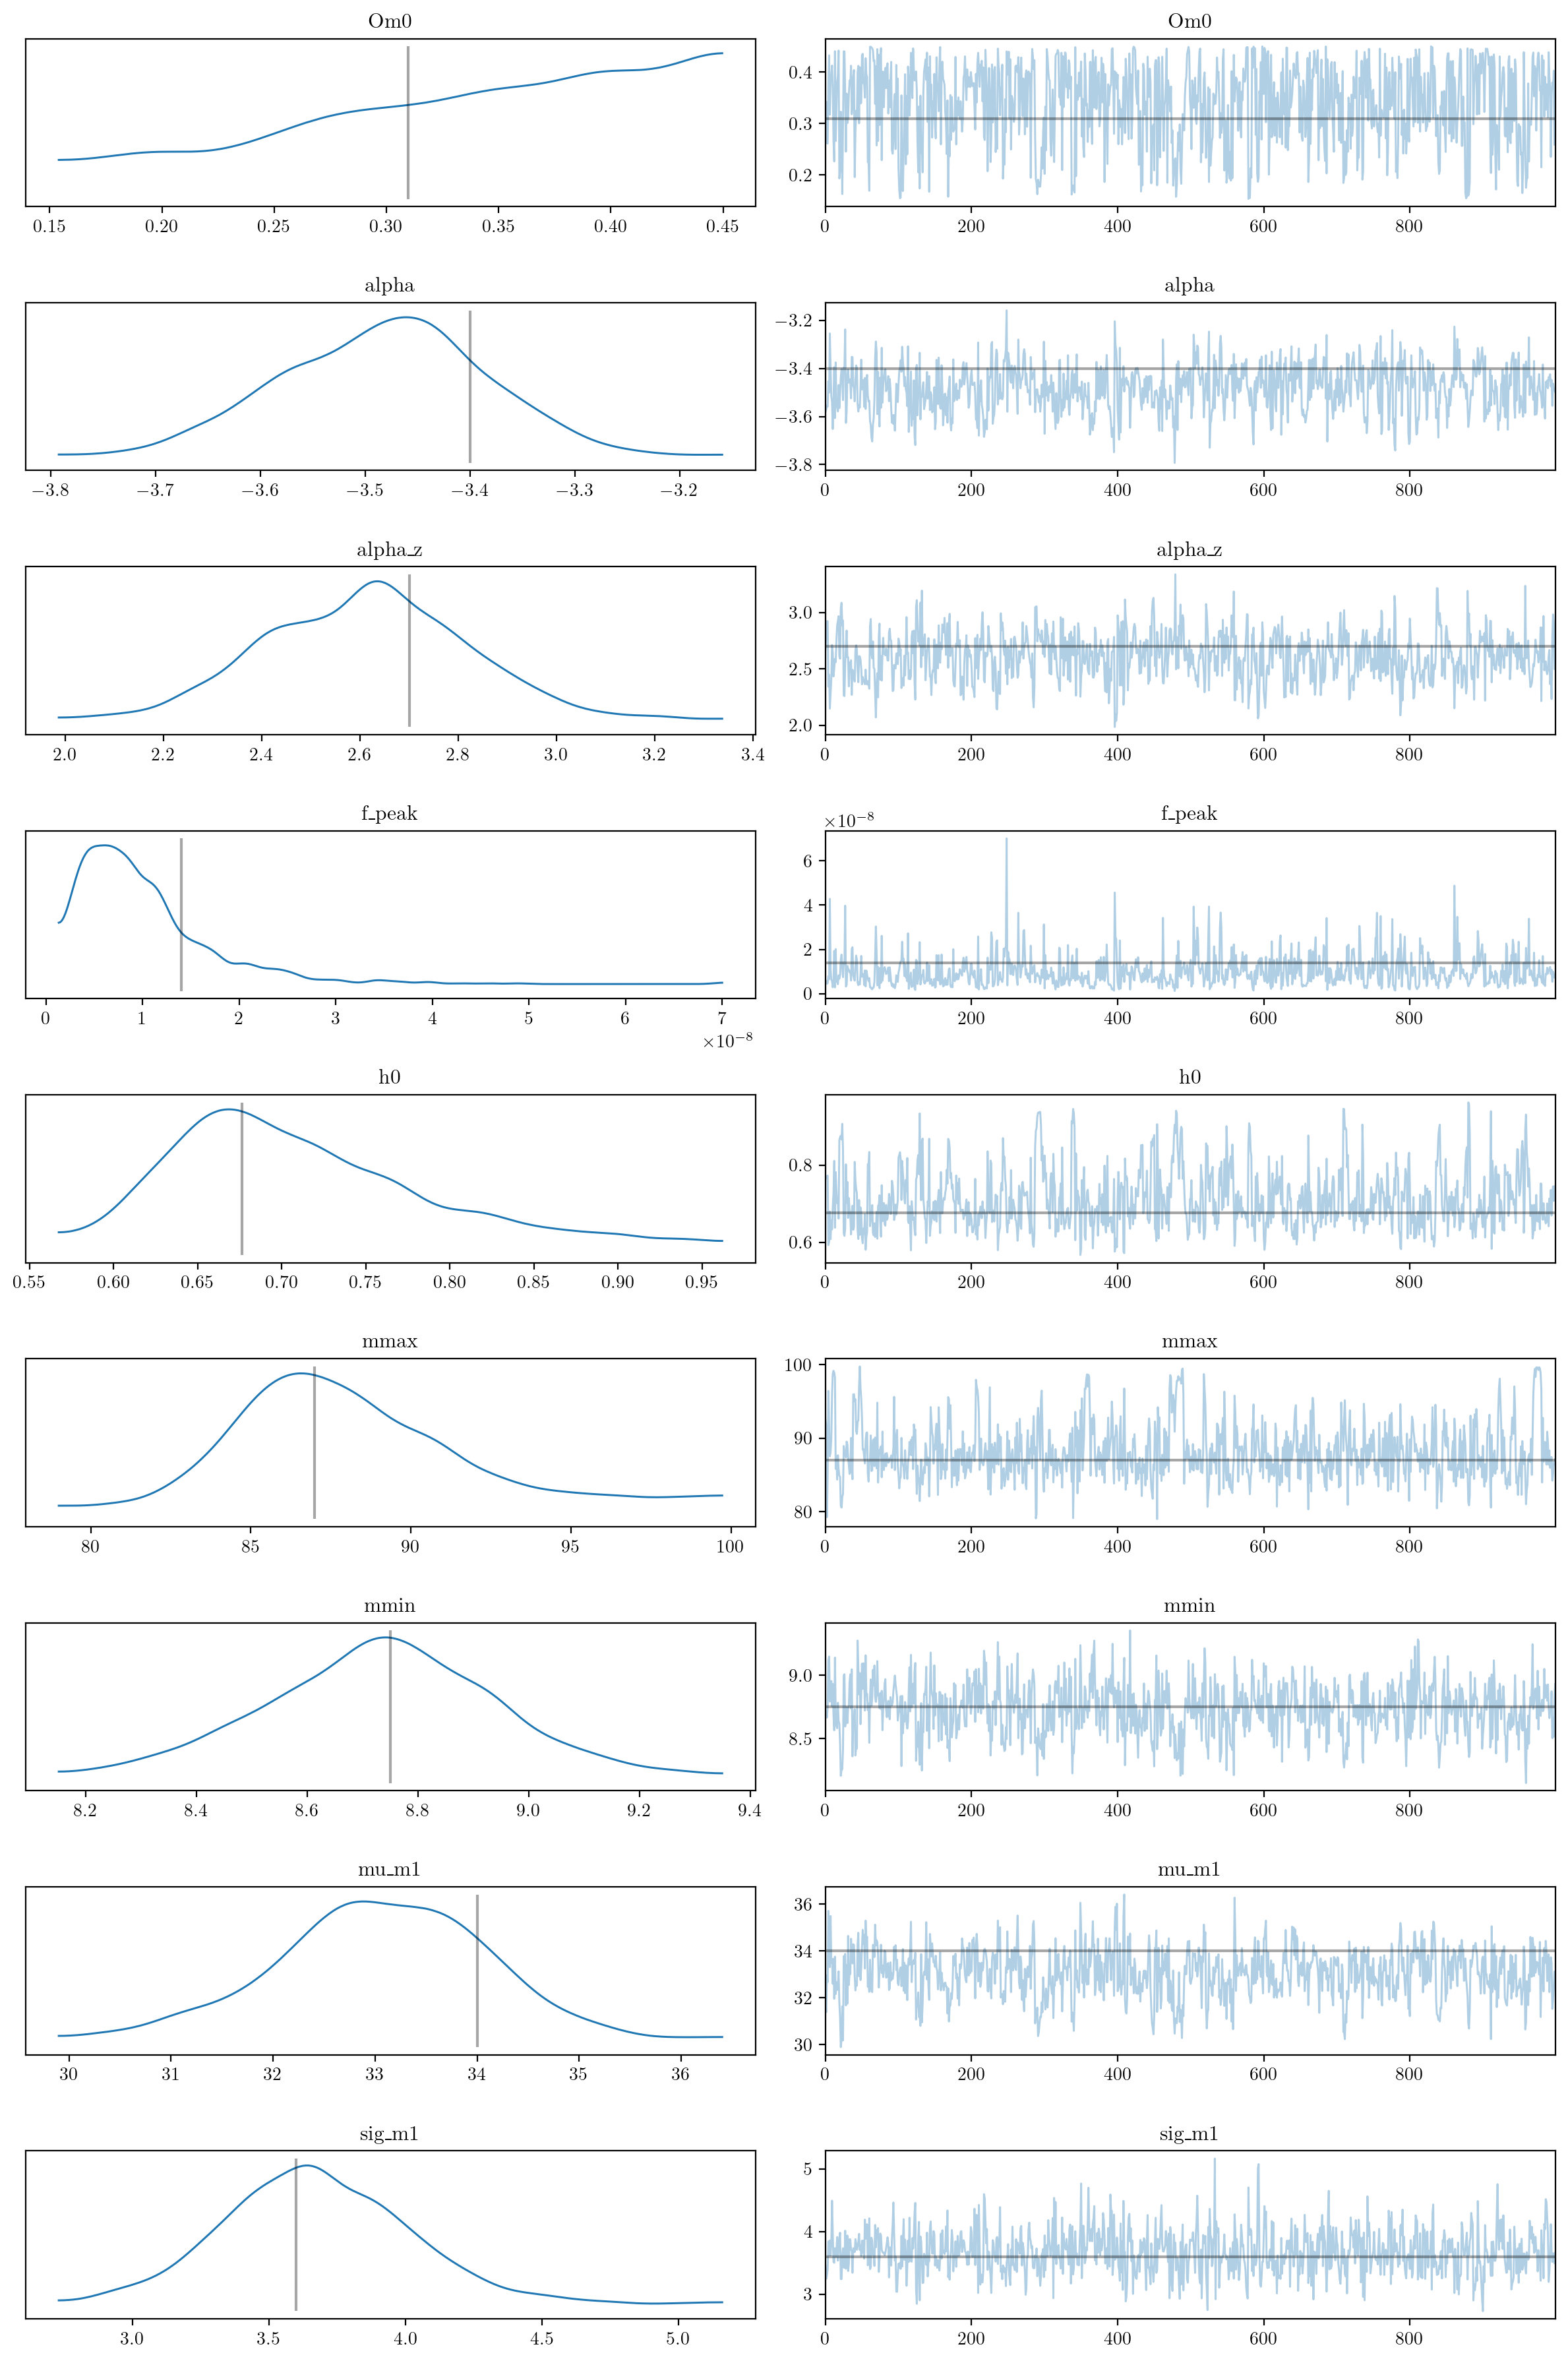

In [12]:
az.plot_trace(mcmc, compact=True, lines=[('h0',{},H0_fid/100),
                                         ('Om0',{},Om0_fid),
                                         (r'mmin',{},mMin_filter_fid),
                                         (r'mmax',{},mMax_filter_fid),
                                         (r'alpha',{},alpha_fid),
                                         (r'mu_m1',{},mu_m1_fid),
                                         (r'sig_m1',{},sig_m1_fid),
                                         (r'f_peak',{},f_peak_fid),
                                         (r'alpha_z',{},alpha_z_fid)]
                                         )
plt.tight_layout()
plt.savefig(f'{PATH}/'+dir_plots+'plot_trace_'+model_name+inference_details+'.pdf')

## Mass spectrum

We compare the inferred mass spectrum with the true mass spectrum.

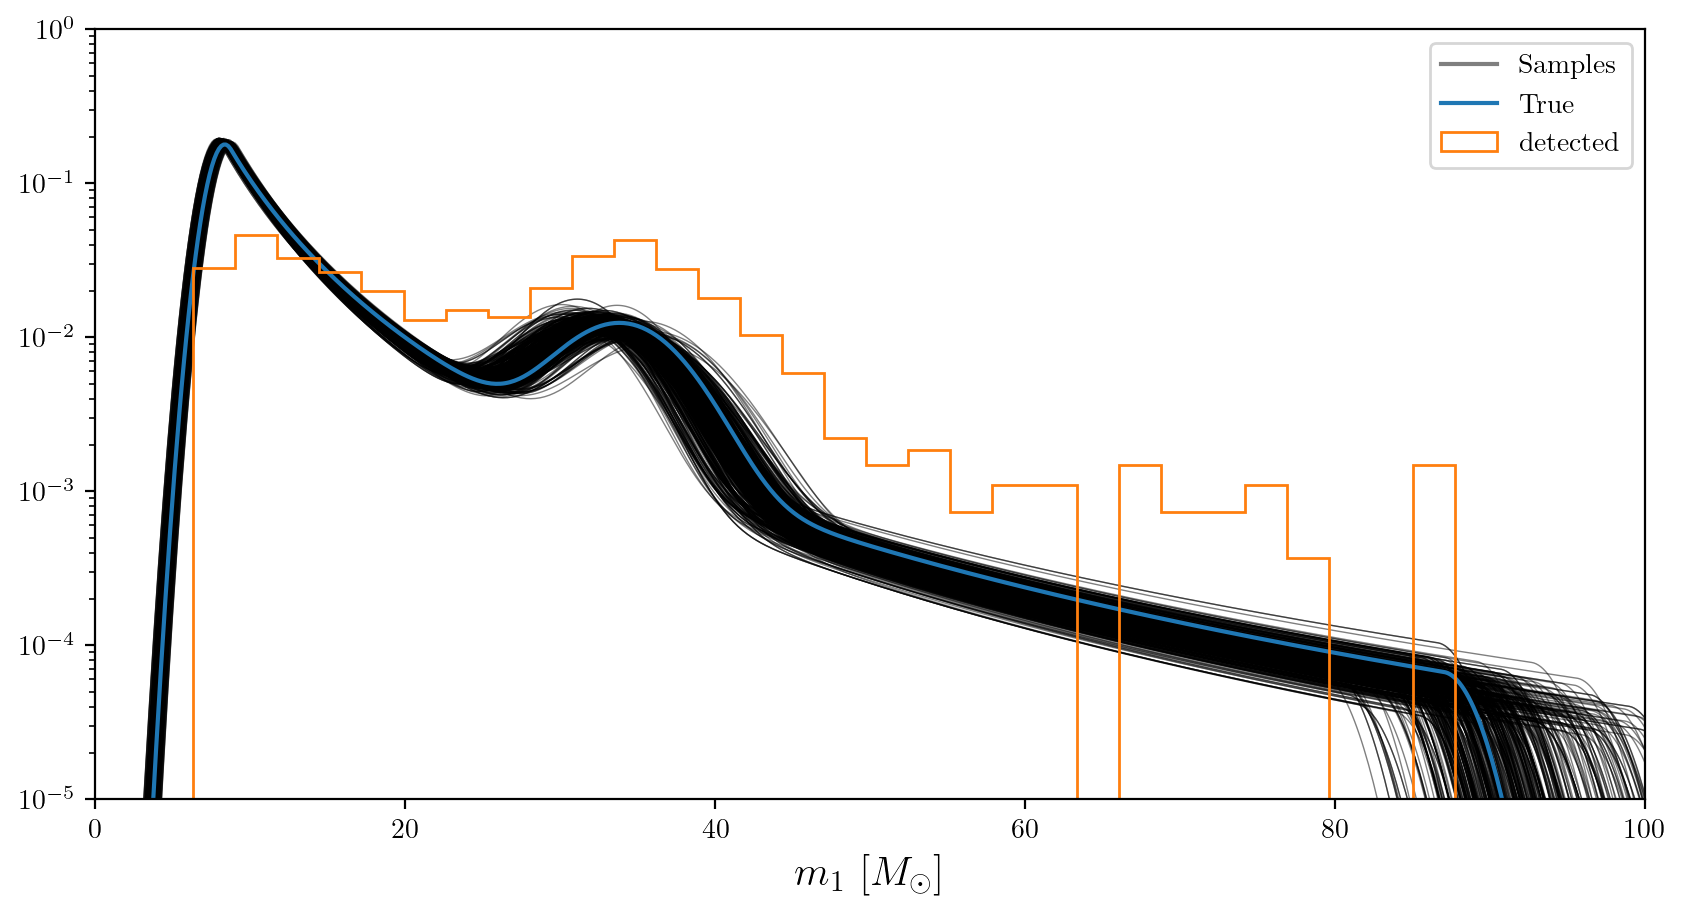

In [13]:
#Plot mass spectrum
fig,ax = plt.subplots(figsize=(10,5))

m1_grid = np.linspace(mmin_pl_fid,mmax_pl_fid,1000)

random_inds = np.random.choice(np.arange(samples['h0'].size),size=500)
for i in random_inds:
    
    p_m1 = jgwpop.powerlaw_peak_smooth(m1_grid,
                                       mmin_pl_fid,
                                       mmax_pl_fid,                                     
                                       samples['alpha'][i],
                                       samples['sig_m1'][i],
                                       samples['mu_m1'][i],
                                       samples['f_peak'][i],
                                       samples['mmin'][i],
                                       samples['mmax'][i],
                                       dmMin_filter_fid,
                                       dmMax_filter_fid
                                       )
    p_m1 /= np.trapz(p_m1,m1_grid)
    
    ax.plot(m1_grid,p_m1,color='black',lw=0.5,alpha=0.5)

massess = np.linspace(mmin_pl_fid,mmax_pl_fid,1000)
pm_true = jgwpop.powerlaw_peak_smooth(massess,mmin_pl_fid,mmax_pl_fid,alpha_fid,sig_m1_fid,mu_m1_fid,f_peak_fid,mMin_filter_fid,mMax_filter_fid,dmMin_filter_fid,dmMax_filter_fid)

pm_true /= jax.scipy.integrate.trapezoid(pm_true,massess)

ax.plot([],'k',alpha=0.5,label='Samples')
ax.semilogy(massess,pm_true,label='True')    

D_H = (Clight/1.0e3)  / H0_fid #Mpc
m1z_mock_O5 = np.median(m1z_mock_samples,axis=1)
m2z_mock_O5 = np.median(m2z_mock_samples,axis=1)
dL_mock_O5 = np.median(dL_mock_samples,axis=1)
m1s_mock, m2s_mock, zs_mock = jgwcosmo.detector_to_source_frame_approx_dLdH(m1z_mock_O5,m2z_mock_O5,dL_mock_O5/D_H,Om0_fid,zmin=1e-3,zmax=100)

ax.hist(m1s_mock,bins=30,density=True, histtype='step',label='detected')

ax.set_yscale('log')
ax.set_ylim(1e-5,1)
ax.set_xlim(0,100)
ax.set_xlabel(r'$m_1$ [$M_{\odot}$]',fontsize=fontSz)
plt.legend()
plt.savefig(f'{PATH}/'+dir_plots+'pm_posteriors_'+model_name+inference_details+'.pdf',bbox_inches='tight')


## Corner plot

_Note:_ Increase the number of samples and chains to improve the convergence of the chains.

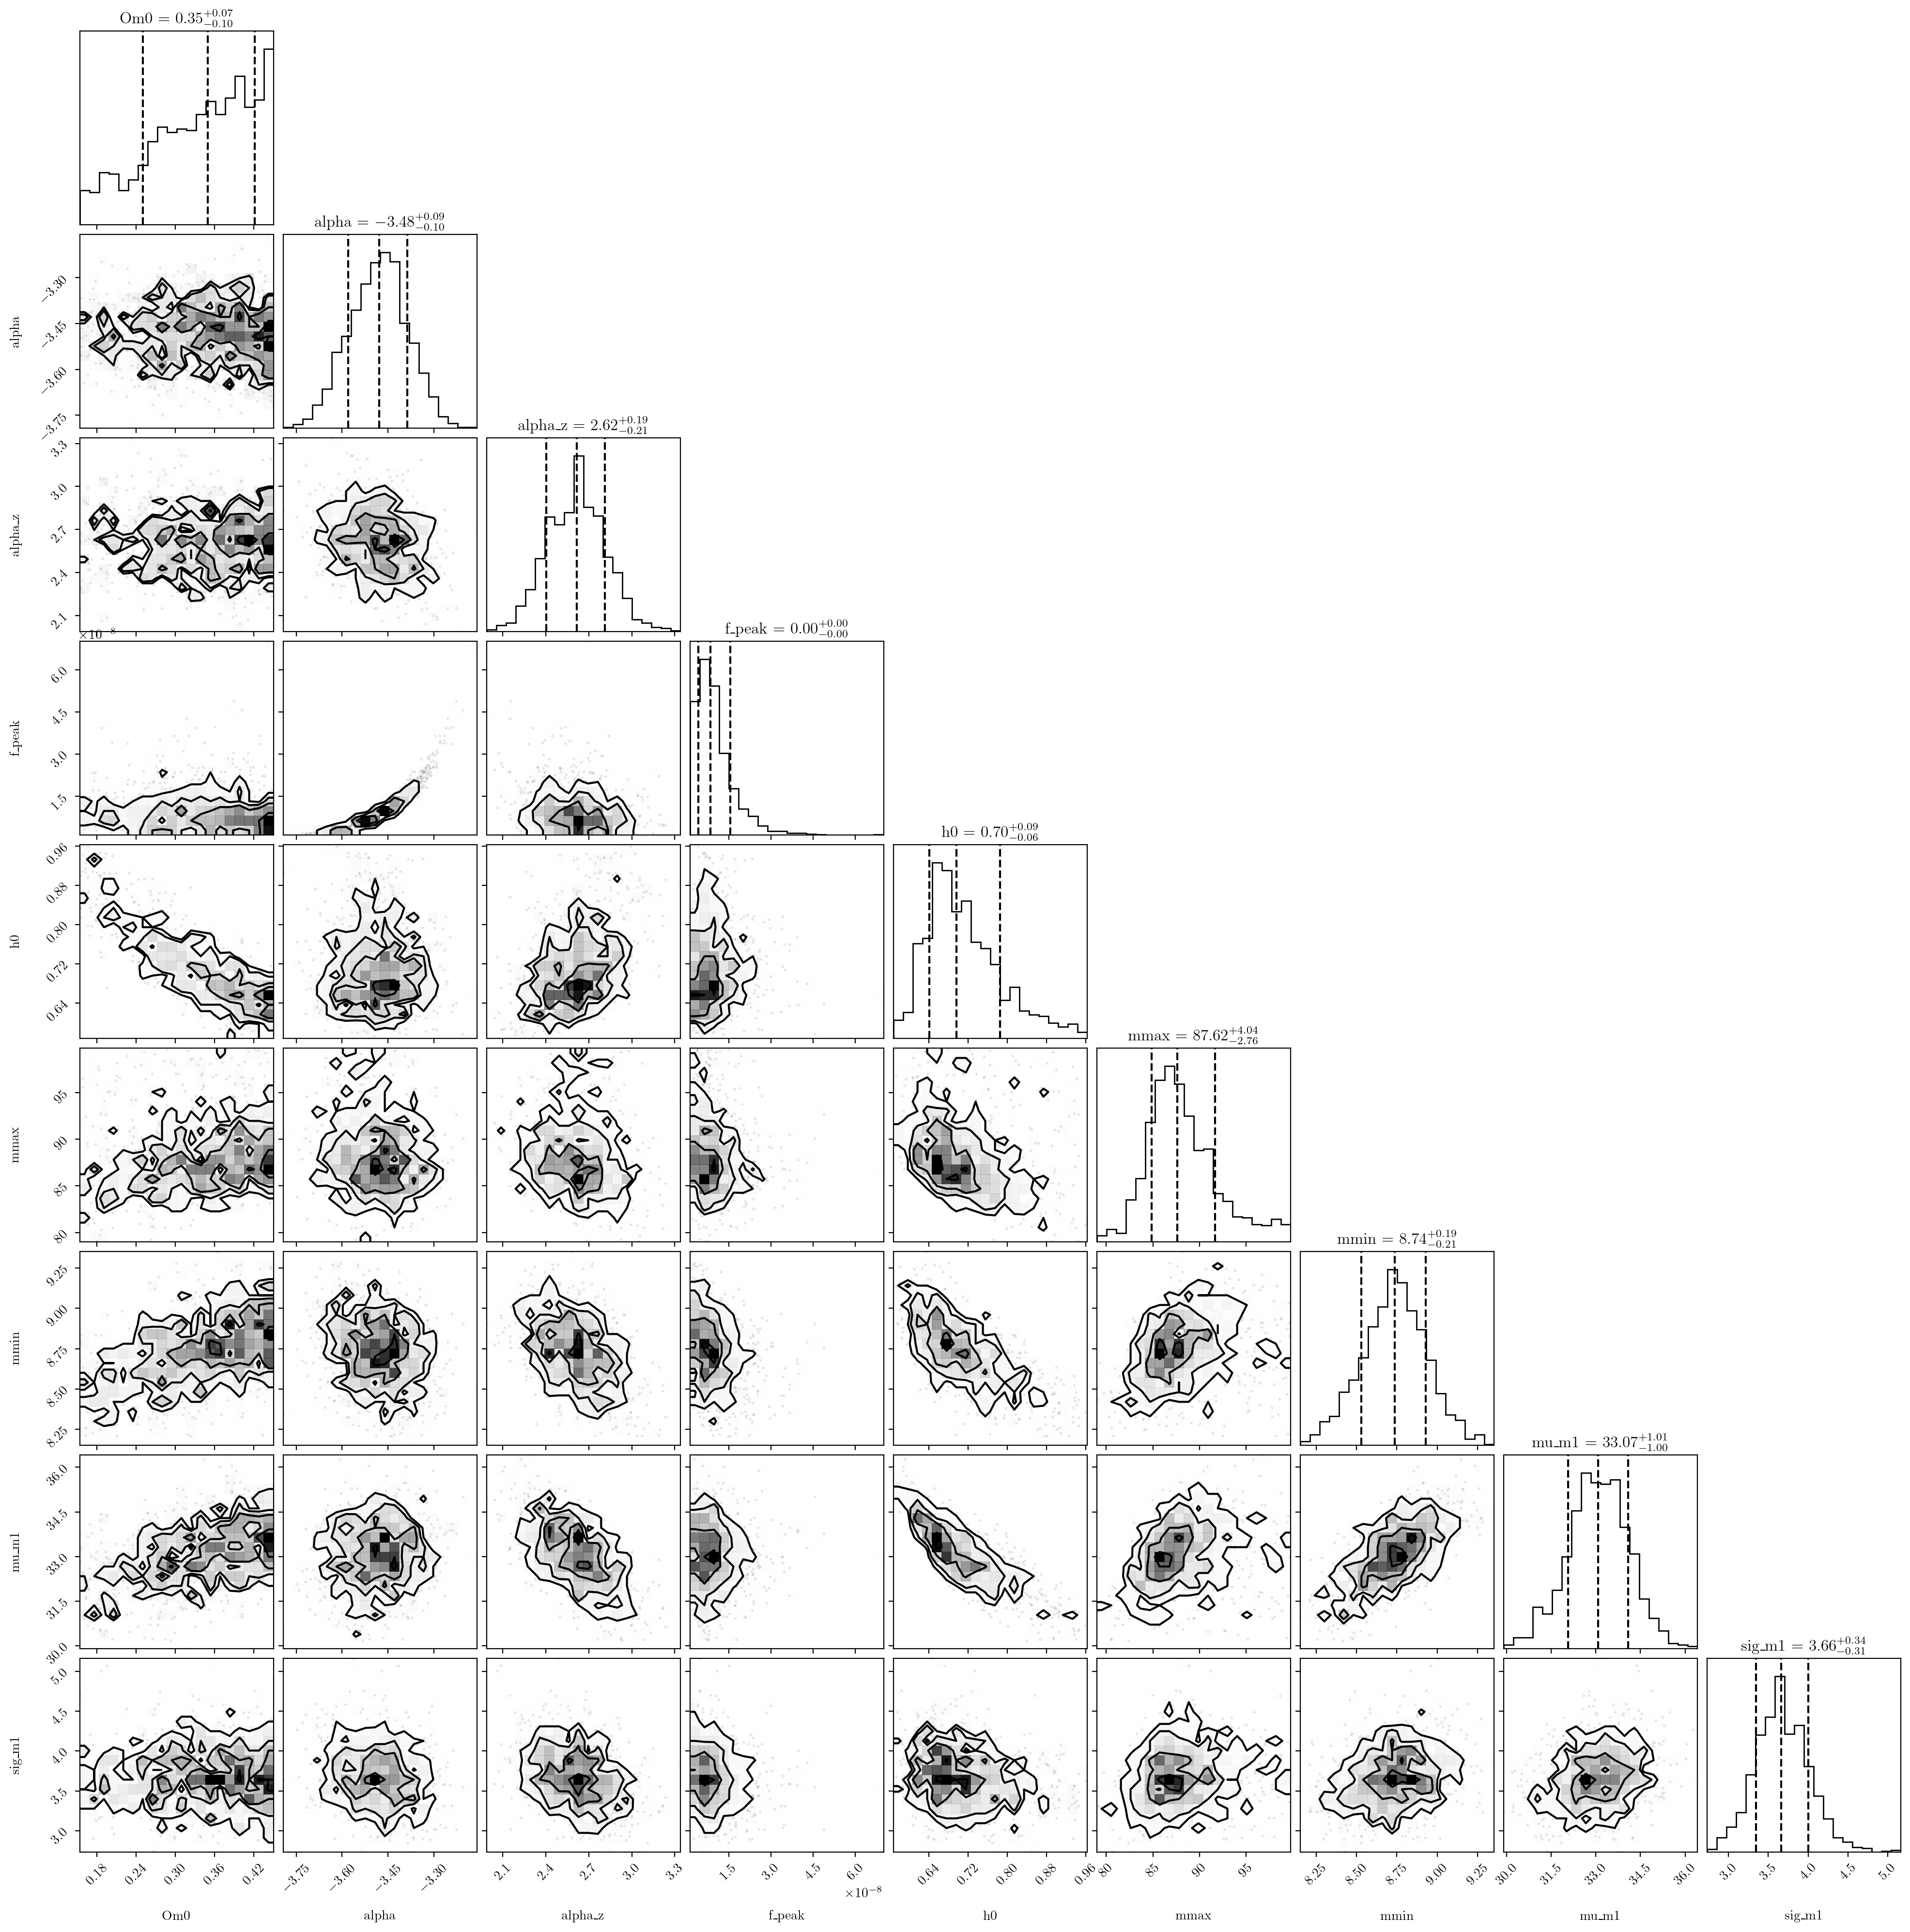

In [14]:
#Corner plot
fig = corner.corner(samples,quantiles=[0.16, 0.5, 0.84],#, labels=labels
                       show_titles=True,fontsize=fontsz)
plt.savefig(f'{PATH}/'+dir_plots+'corner_'+model_name+inference_details+'.pdf',bbox_inches='tight')

---

## Saving the results

In [15]:
#Save samples to hdf5
hf = h5py.File(f'{PATH}/'+dir_samples+'samples_'+model_name+inference_details+'.hdf5', 'w')
for key in samples.keys():
    hf.create_dataset(key, data=samples[key])
hf.close()

---
# Notes on hierarchical Bayesian inference

## Likelihood

We are solving the hierarchical inference of a Poissonian proccess described by the population distribution

$$\frac{dN(\lambda)}{d\theta}=\frac{p_{pop}(\theta|\lambda)}{N}$$

where $\lambda$ are the hyperparameters of the model (power-law+peak + SFR + LCDM in our case) and $\theta$ the parameters that can be observed ($m_z$ and $d_L$ in our case).

The population likelihood is given by

$$p(\lambda)=\prod_{i}^{N_{obs}}\frac{\int d\theta p(d_i|\theta_i)p_{pop}(\theta_i|\lambda)}{\int d\theta p_{det}(\theta)p_{pop}(\theta|\lambda)}
\propto\prod_{i}^{N_{obs}}\frac{\int d\theta p_{pop}(\theta_i|\lambda)p(\theta_i|d_i/\pi_{pe}(\theta)}{\int d\theta p_{det}(\theta)p_{pop}(\theta|\lambda)}
\approx \left(\frac{N_{det}}{N}\right)^{-N_{obs}}\prod_{i}^{N_{obs}}\left\langle \frac{dN/d\theta}{N \pi_{pe}}\right\rangle_{p(\theta_i|d)}$$

where we have transformed the likelihood of the data into its posterior distribution (with the proper PE prior $\pi_{pe}(\theta)$- in our case the weigths from sampling the posteriors in different variables) and we have neglected the evidence of the data $p(d_i)$ that would cancel out when computing the posterior distribution. Then, we have approximated the expression with a Monte Carlo integral over the posterior samples of the data.

Here the expected number of detections is

$$N_{det} = N \int d\theta p_{det}(\theta)p_{pop}(\theta|\lambda) \approx N \frac{1}{N_{draw}}\sum_{j}^{N_{found}}\frac{dN/d\theta(\theta_j|\lambda)}{p_{draw}(\theta_j)}$$

that can be approximated with an injection campaign to account for the detector's sensitivity.

Note that the total rate $N$ cancels in this expression so that

$$\log p(\lambda)\approx -N_{obs}\cdot\log N_{det} + \sum_{i}^{N_{obs}}\log\left\langle \frac{dN/d\theta}{ \pi_{pe}}\right\rangle_{p(\theta_i|d)}$$

This is not the case however when the selection effects are neglected.

When considering the Poisson process with rate $N$ but marginalize over the total rate $N$ assuming a $1/N$ prior, we also get to the same expression modulo an overall constant that does not affect the inference. 


*Nice references:* https://arxiv.org/pdf/1809.02063.pdf, https://arxiv.org/pdf/1904.10879.pdf


## Jacobians

For this particular problem we are using data in detector frame masses and luminosity distances, but we are fitting models in the source masses and redshifts. This means that 

$$\frac{dN}{dm_zdd_L}=\frac{dN}{dmdz}\left|\frac{\partial z}{\partial d_L}\right|\left|\frac{\partial m}{\partial m_z}\right|$$

where

$$\frac{\partial d_L}{\partial z}= \frac{d_L}{1+z} + (1+z)\frac{D_H}{E(z)}$$

$$\frac{\partial m_z}{\partial m}= (1 + z)$$

If we want to fit in mass ratio then we need to add another Jacobian

$$\frac{\partial (m_1,q)}{\partial (m_1,m_2)}= \frac{1}{m_1}$$